## 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

import joblib
import warnings
warnings.filterwarnings('ignore')


import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kenneth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kenneth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Define Helper Functions

In [ ]:
def preprocess_text(text):

    # Converting to lowercase
    text = text.lower()
    
    # Handling repeated characters like gooooood  will change to good
    text = re.sub(r'(.)\1+', r'\1\1', text)
    
    # Keeping important punctuation and emojis as they may convey positive and negative expressions here
    text = re.sub(r'[^a-zA-Z0-9\s.,!?$%&*()_+\-=\[\]{};\'"\\|,.<>\/?]', ' ', text)
    
    # Handle negation words
    negation_words = {'not', 'no', 'never', 'none', 'neither', 'nor', 'cannot', 'didnt', 'doesnt', 
                     'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'wasnt', 'werent', 'wont', 'wouldnt'}
    
    # Tokenizing 
    words = text.split()
    
    # Remove stopwords but keeping negation words
    stop_words = set(stopwords.words('english')) - negation_words
    words = [word for word in words if word not in stop_words]
    
    # Apply stemming, converting words to its root form 
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    return ' '.join(words) #since it returns list of words we have to join them

def categorize_text(text, target):
    
    return ['positive'] if target == 4 else ['negative']

## 3. Load and Prepare Data

In [ ]:
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
twitter_data = pd.read_csv('training.1600000.processed.noemoticon.csv',
                          names=column_names,
                          encoding='ISO-8859-1')


print("Dataset Shape:", twitter_data.shape) #shape of the dataset

Loading dataset...

Dataset Shape: (1600000, 6)


In [ ]:
# Converting target values to categories
twitter_data['category'] = twitter_data['target'].map({0: 'negative', 4: 'positive'})

# Applying categorization as defined in the earlier cell
print("Categorizing content...")
twitter_data['categories'] = twitter_data.apply(lambda row: categorize_text(row['text'], row['target']), axis=1)

# Displaying category distribution
print(twitter_data['categories'].value_counts())

Categorizing content...

Category Distribution:


categories
[negative]    800000
[positive]    800000
Name: count, dtype: int64

## 4. Feature Extraction

In [ ]:
# Fitting the vectorizer on the entire dataset
vectorizer = TfidfVectorizer(
    max_features=10000,  # keeping only 10000 most imp words
    ngram_range=(1, 3), # helps make the model understand short phrases and not single words
    min_df=2, # ignore words that appear less than 2 in documents
    max_df=0.95, # ignore words that appear more than 95% in the documents. They act like stopwords
    analyzer='word', # tells the vectorizer to analyze at the word level and not characters or something else
    sublinear_tf=True # helps make the model more balanced if set to True
)

# Transforming the text data
X = vectorizer.fit_transform(twitter_data['text'])

# Converting target values to binary (0 for negative, 1 for positive)
y = (twitter_data['target'] == 4).astype(int)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Extracting features...
Fitting vectorizer...


## 5. Model Training

In [ ]:
# Initializing and train the model
from sklearn.svm import LinearSVC

# Initializing and train the model
print("\nTraining model...")
model = LinearSVC(class_weight='balanced', max_iter=1000, dual=False)

# Training on the entire dataset at once
print("Training on full dataset...")
model.fit(X_train, y_train)
print("Training completed!")


Training model...
Training on full dataset...
Training completed!


## 6. Model Evaluation

In [ ]:
# Evaluating model
y_pred = model.predict(X_test)

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

Evaluating model...


Evaluating model...


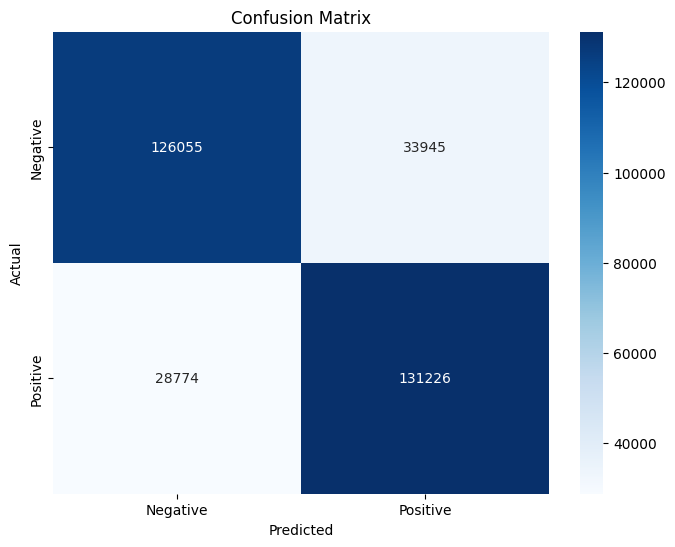


Model Performance Metrics:
Accuracy: 0.8040
Precision: 0.8043
Recall: 0.8040
F1 Score: 0.8040

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.79      0.80    160000
    Positive       0.79      0.82      0.81    160000

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



In [ ]:
# Creating confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Creating figure and axis
plt.figure(figsize=(8, 6))

# Creating heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


plt.show()


print("Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print detailed classification report
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

## 7. Testing with Example Texts

In [ ]:
# Example predictions as a test
print("Testing model with example texts...")
test_texts = [
    "This is a normal message",
    "Buy now! Limited time offer!",
    "I hate you all",
    "This is a helpful comment",
    "I will kill you all",
    "Hope your exams went well"
]

for text in test_texts:
    processed_text = preprocess_text(text)
    text_features = vectorizer.transform([processed_text])
    prediction = model.predict(text_features)[0]
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"\nText: '{text}'")
    print(f"Predicted sentiment: {sentiment}")

Testing model with example texts...

Text: 'This is a normal message'
Predicted sentiment: Positive

Text: 'Buy now! Limited time offer!'
Predicted sentiment: Positive

Text: 'I hate you all'
Predicted sentiment: Negative

Text: 'This is a helpful comment'
Predicted sentiment: Positive

Text: 'I will kill you all'
Predicted sentiment: Negative

Text: 'Hope your exams went well'
Predicted sentiment: Positive


In [ ]:

# Save the model and components
joblib.dump(model, 'content_moderation_model.joblib')
joblib.dump(vectorizer, 'text_vectorizer.joblib')
print("Saved the model successfully")


Saving model and components...


['text_vectorizer.joblib']